# 課題4: プロ野球選手の年俸データのクラスタリング

ここでは、k-means法を利用したクラスタリングの理解を深めて頂くための課題を用意しました。Lesson6で使用したプロ野球選手の推定年俸のデータを使い、クラスタリングを行ってください。なお、クラスタリングはデータを正規化したうえで行ないます。

わからない場合は、ここまでのレッスン内容や各種ライブラリの公式ドキュメントを参照しましょう。

## 1. ライブラリのimport

In [53]:
# （変更しないでください）

# 必要なライブラリのimport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# データの正規化
from sklearn.preprocessing import MinMaxScaler

# k-means法
from sklearn.cluster import KMeans

# シルエットプロット
from sklearn.metrics import silhouette_score, silhouette_samples

# DataFrameですべての列を表示する設定
pd.options.display.max_columns = None

# seabornによる装飾を適用する
sns.set_theme()

## 2. データの読み込み

CSVファイル *baseball_salary.csv* を読み込み、dataset_baseに格納します。

In [54]:
# CSVファイルを読み込んでdataset_baseに格納する
dataset_base = pd.read_csv('baseball_salary.csv')

In [55]:
# dataset_baseの最初の5行を表示
dataset_base.head(5)

,球団,推定年俸,守備,年数,年齢,身長,体重,血液型,投打,年,打率,試合,打席数,打数,安打,本塁打,打点,盗塁,四球,死球,三振,犠打,併殺打,出塁率,長打率,OPS,RC27,XR27,球団勝率,プレーオフ,球団平均得点,球団打率
0,c,21000,外野手,11,29,177,90,AB型,右左,2017,0.308,143,651,556,171,23,92,13,83,4,113,2,6,0.398,0.505,0.903,7.70,7.52,0.633,2,5.15,0.273
1,c,19000,内野手,7,28,171,72,A型,右右,2017,0.271,138,629,565,153,14,56,8,32,1,107,30,9,0.311,0.405,0.716,4.10,4.01,0.633,2,5.15,0.273
2,c,14000,内野手,5,29,171,85,A型,右左,2017,0.290,143,679,565,164,8,60,35,89,15,120,6,5,0.398,0.407,0.805,6.41,6.26,0.633,2,5.15,0.273
3,c,11500,内野手,7,38,196,126,不明,右右,2017,0.265,116,405,344,91,27,78,0,50,8,111,0,8,0.368,0.532,0.900,6.80,6.90,0.633,2,5.15,0.273
4,c,11000,内野手,20,41,189,102,B型,右右,2017,0.292,100,288,243,71,9,48,2,40,1,56,0,7,0.389,0.461,0.850,6.55,6.54,0.633,2,5.15,0.273


In [56]:
# dataset_baseから「打率、打点」列を抜き出してdatasetに格納する
dataset = dataset_base[['打率', '打点']]

# 列名を、打率は「batting」、打点は「points」にリネームする
dataset = dataset.rename(columns={'打率': 'batting', '打点': 'points'})

# datasetの先頭の5行を表示
dataset.head(5)

,batting,points
0,0.308,92
1,0.271,56
2,0.290,60
3,0.265,78
4,0.292,48


## 3. データの正規化

クラスタリングは類似度（距離）に基づいて行なわれるため、データの範囲に差がある場合は正規化を行ないます。

ここでは、Lesson5のデータの前処理で紹介した *Min-max normalization* を使ってみましょう。 `sklearn.preprocessing.MinMaxScaler()` を利用します。

参考：https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [57]:
# MinMaxScalerで正規化を実施し、その結果を変数tempに格納する
ms = MinMaxScaler()
temp = ms.fit_transform(dataset)

In [58]:
# 正規化後のデータの先頭の5行を表示
print(temp[:5])

[[0.616      0.87619048]
 [0.542      0.53333333]
 [0.58       0.57142857]
 [0.53       0.74285714]
 [0.584      0.45714286]]


In [59]:
# tempの0列目を「batting_scaled」、1列目を「points_scaled」という列名にして、datasetへ列として追加
dataset['batting_scaled'] = temp[:, 0]
dataset['points_scaled'] = temp[:, 1]

In [60]:
# 改めてdatasetの先頭の5行を表示
dataset.head(5)

,batting,points,batting_scaled,points_scaled
0,0.308,92,0.616,0.876190
1,0.271,56,0.542,0.533333
2,0.290,60,0.580,0.571429
3,0.265,78,0.530,0.742857
4,0.292,48,0.584,0.457143


## 4. データの可視化

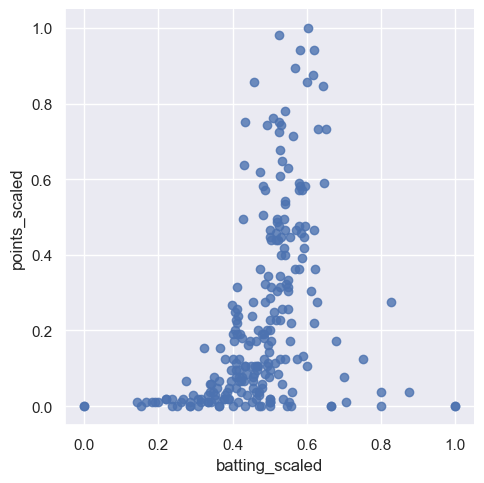

In [61]:
# 正規化後の打率と打点の散布図を描画する
sns.lmplot(x='batting_scaled', y='points_scaled', data=dataset, fit_reg=False)

## 5. クラスター数の決定

エルボーメソッドとシルエットプロットを使用してクラスター数を決定しましょう

### クラスタリングを行なうデータの抽出

In [62]:
# datasetからbatting_scaledとpoints_scaledを取り出して、numpy配列に変換してXに格納する
X = dataset[['batting_scaled', 'points_scaled']].values

# Xの形状を確認
print(X)

[[0.616      0.87619048]
 [0.542      0.53333333]
 [0.58       0.57142857]
 [0.53       0.74285714]
 [0.584      0.45714286]
 [0.6        0.85714286]
 [0.408      0.11428571]
 [0.652      0.73333333]
 [0.55       0.33333333]
 [0.62       0.46666667]
 [0.35       0.07619048]
 [0.512      0.24761905]
 [0.378      0.01904762]
 [0.55       0.25714286]
 [0.75       0.12380952]
 [0.378      0.01904762]
 [0.434      0.1047619 ]
 [0.47       0.02857143]
 [0.25       0.        ]
 [0.8        0.        ]
 [0.666      0.        ]
 [0.5        0.01904762]
 [0.58       0.59047619]
 [0.586      0.39047619]
 [0.526      0.75238095]
 [0.456      0.04761905]
 [0.618      0.21904762]
 [0.568      0.36190476]
 [0.5        0.22857143]
 [0.482      0.58095238]
 [0.412      0.31428571]
 [0.474      0.36190476]
 [0.42       0.19047619]
 [0.452      0.23809524]
 [0.522      0.08571429]
 [0.39       0.04761905]
 [0.154      0.        ]
 [0.518      0.22857143]
 [0.496      0.16190476]
 [0.236      0.        ]


### エルボーメソッド

In [68]:
# 最大クラスター数を10として、クラスター数1から10までのWCSS値を算出（変更しないでください）
wcss = []
c_list = np.arange(1, 11)

In [69]:
# クラスタ数の算出
for c in c_list:
    # クラスタ数を c で指定
    kmeans_model = KMeans(n_clusters=c, init='k-means++', n_init=10)
    kmeans_model.fit(X)
    # inertia_プロパティに、WCSSが格納されている
    wcss.append(kmeans_model.inertia_)

In [70]:
# WCSSの表示（変更しないでください）
wcss

[19.166235457325396,
 7.41051670525134,
 5.207722431334771,
 3.6885654218966573,
 2.595532327113087,
 1.92638297633886,
 1.6618496192746393,
 1.4184096892872897,
 1.2290612814883533,
 1.1053822767953552]

<Axes: >

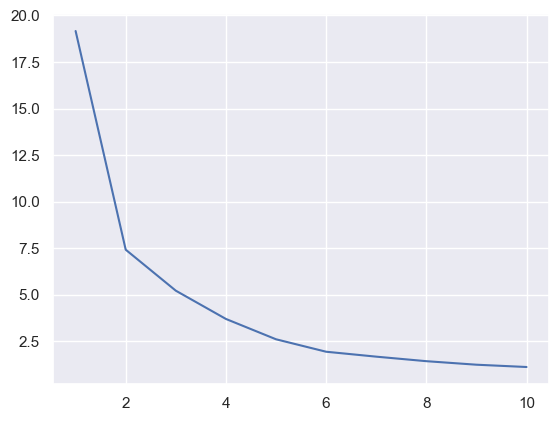

In [71]:
# エルボーメソッドのグラフの表示
sns.lineplot(x=c_list, y=wcss)

### シルエットプロット

In [72]:
# クラスタ数を6に指定（変更しないでください）
cluster_no = 6

In [73]:
# クラスタリングのモデルを作成し、学習して、クラスタ番号を取得
kmeans_model = KMeans(n_clusters=cluster_no, init='k-means++', n_init=10)
Y_pred = kmeans_model.fit_predict(X)

In [74]:
# シルエットスコアの平均値
s_average = silhouette_score(X, Y_pred)

# 各データのシルエットスコア
s_score = silhouette_samples(X, Y_pred, metric='euclidean')

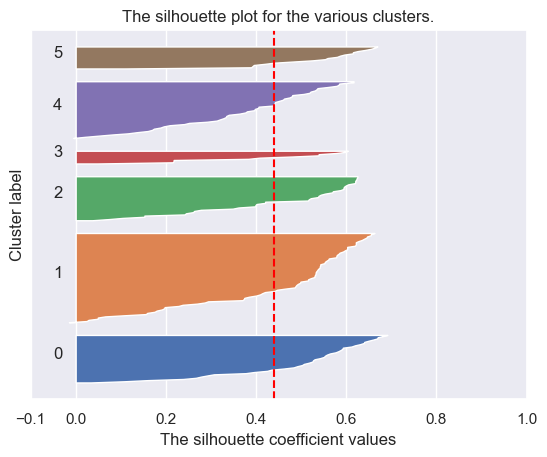

In [75]:
# シルエットプロットを描画
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
y_lower = 0

for i in range(cluster_no):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = s_score[Y_pred == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    #color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the space between silhouette plots

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=s_average, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## 6. 結果の確認

上記の結果をもとに、クラスタ数6で再度クラスタリングを実行し、分類ごとに色を分けて散布図にプロットしましょう。

In [79]:
# クラスタ数を6に指定（変更しないでください）
cluster_no = 6

# クラスタリングのモデルを作成し、学習して、クラスタ番号を取得
kmeans_model = KMeans(n_clusters=cluster_no, init='k-means++', n_init=10)
Y_pred = kmeans_model.fit_predict(X)

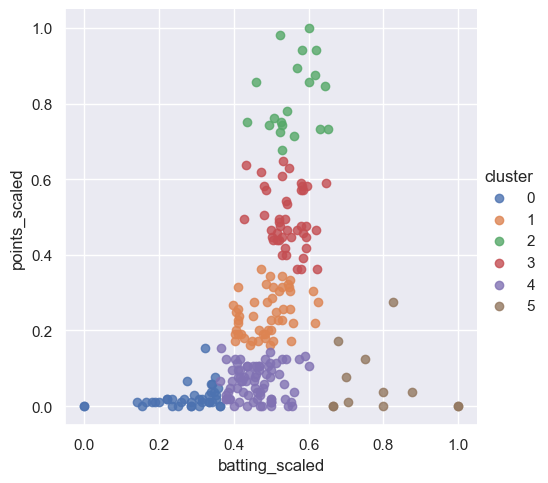

In [86]:
# k-means法によるクラスタリングの結果を描画
dataset['cluster'] = Y_pred
sns.lmplot(x='batting_scaled', y='points_scaled', data=dataset, hue='cluster', fit_reg=False)